# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name='/home/slavo/Dev/deep-rl-projects/ma_collab-compet/Tennis_Linux/Tennis.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


When finished, you can close the environment.

In [6]:
env.close()

### 4. Multi Agent DDPG

In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

from collections import deque
from agent import MADDPG
from buffer import ReplayBuffer
from utils import transpose_list, transpose_to_tensor
from unityagents import UnityEnvironment

BUFFER_SIZE = 100000  # replay buffer size
BATCH_SIZE = 1024 # minibatch size

In [2]:
def seeding(seed=1):
    np.random.seed(seed)
    torch.manual_seed(seed)


def train():
    seeding()

    os.environ["CUDA_VISIBLE_DEVICES"] = "1"

    print("GPU available: {}".format(torch.cuda.is_available()))
    print("GPU tensor test: {}".format(torch.rand(3, 3).cuda()))

    env = UnityEnvironment(file_name='/home/slavo/Dev/deep-rl-projects/ma_collab-compet/Tennis_Linux/Tennis.x86_64', no_graphics=True)

    # get the default brain
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]

    # reset the environment
    env_info = env.reset(train_mode=True)[brain_name]

    # number of agents in the environment
    print('Number of agents:', len(env_info.agents))

    # number of actions
    action_size = brain.vector_action_space_size
    print('Number of actions:', action_size)

    # examine the state space
    state = env_info.vector_observations[0]
    print('States look like:', state)
    state_size = len(state)
    print('States have length:', state_size)

    agents = len(env_info.agents)

    # number of training episodes.
    # change this to higher number to experiment. say 30000.
    number_of_episodes = 30000
    episode_length = 500

    # how many steps before update
    steps_per_update = 100

    # amplitude of OU noise
    # this slowly decreases to 0
    noise = 1
    noise_reduction = 0.9999

    torch.set_num_threads(4)

    buffer = ReplayBuffer(BUFFER_SIZE)

    # initialize policy and critic
    maddpg_agent = MADDPG(state_size, action_size, agents)

    scores = []
    scores_window = deque(maxlen=100)  # last 100 scores

    actor_losses = []
    critic_losses = []
    for i in range(len(env_info.agents)):
        actor_losses.append([])
        critic_losses.append([])

    for episode in range(0, number_of_episodes):

        episode_rewards = []

        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        state_full = np.concatenate(state)

        # for calculating rewards for this particular episode - addition of all time steps
        for episode_t in range(episode_length+1):

            actions = maddpg_agent.act(transpose_to_tensor(list(state)), noise=noise)
            noise *= noise_reduction

            actions = torch.stack(actions).view(-1).detach().cpu().numpy()
            env_info = env.step(actions)[brain_name]

            state_next = env_info.vector_observations  # get the next state
            state_next_full = np.concatenate(state_next)
            rewards = env_info.rewards  # get the reward
            dones = env_info.local_done  # see if episode has finished

            # add experiences to buffer
            transition = (state, state_full, actions, rewards, state_next, state_next_full, dones)
            buffer.push(transition)

            episode_rewards.append(rewards)
            state, state_full = state_next, state_next_full

            # update once after every steps_per_update
            if len(buffer) > BATCH_SIZE and (episode_t > 0) and (episode_t % steps_per_update == 0):
                # print('maddpg update after {} steps'.format(episode_t))
                for agent_idx in range(len(env_info.agents)):
                    samples = buffer.sample(BATCH_SIZE)
                    al, cl = maddpg_agent.update(samples, agent_idx)
                    actor_losses[agent_idx].append(al)
                    critic_losses[agent_idx].append(cl)
                maddpg_agent.update_targets()  # soft update the target network towards the actual networks

        # calculate agent episode rewards
        agent_episode_rewards = []
        for i in range(len(env_info.agents)):
            agent_episode_reward = 0
            for step in episode_rewards:
                agent_episode_reward += step[i]
            agent_episode_rewards.append(agent_episode_reward)

        scores.append(np.max(agent_episode_rewards))
        scores_window.append(np.max(agent_episode_rewards))

        if episode > 10 and episode % 10 == 0:
            print('\rEpisode {}\tAgent Rewards [{:.4f}\t{:.4f}]\tMax Reward {:.4f}'.format(episode,
                                                                                           agent_episode_rewards[0],
                                                                                           agent_episode_rewards[1],
                                                                                           np.max(agent_episode_rewards)))

            print('\rEpisode {}\tAverage Actor 1 Loss {:.6f}\tAverage Critic 1 Loss {:.6f}'
                  '\tAverage Actor 2 Loss {:.6f}\tAverage Critic 2 Loss {:.6f}'.format(episode,
                                                                                       np.mean(actor_losses[0]),
                                                                                       np.mean(critic_losses[0]),
                                                                                       np.mean(actor_losses[1]),
                                                                                       np.mean(critic_losses[1])))

            print('\rEpisode {}\tAverage Score: {:.4f}'.format(episode, np.mean(scores_window)))

            # reset losses
            actor_losses = []
            critic_losses = []
            for i in range(len(env_info.agents)):
                actor_losses.append([])
                critic_losses.append([])

        if episode > 100 and episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.4f}'.format(episode, np.mean(scores_window)))

        if episode > 100 and np.mean(scores_window) >= 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.4f}'.format(episode - 100,
                                                                                         np.mean(scores_window)))
            for i, save_agent in enumerate(maddpg_agent.agents):
                torch.save(save_agent.actor.state_dict(), './checkpoints/checkpoint_actor_'+str(i)+'.pth')
                torch.save(save_agent.critic.state_dict(), './checkpoints/checkpoint_critic_'+str(i)+'.pth')
            break

    env.close()
    return scores

In [3]:
scores = train()

GPU available: True
GPU tensor test: tensor([[0.7576, 0.2793, 0.4031],
        [0.7347, 0.0293, 0.7999],
        [0.3971, 0.7544, 0.5695]], device='cuda:0')


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2
Number of actions: 2
States look like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
States have length: 24
Episode 20	Agent Rewards [-0.1400	-0.2100]	Max Reward -0.1400
Episode 20	Average Actor 1 Loss -0.064682	Average Critic 1 Loss 0.635051	Average Actor 2 Loss -0.063351	Average Critic 2 Loss 0.632704
Episode 20	Average Score: 0.1757
Episode 30	Agent Rewards [-0.1600	-0.1900]	Max Reward -0.1600
Episode 30	Average Actor 1 Loss -0.054901	Average Critic 1 Loss 0.001095	Average Actor 2 Loss -0.048698	Average Critic 2 Loss 0.001345
Episode 30	Average Score: 0.0697
Episode 40	Agent Rewards [0.5200	-0.2000]	Max Reward 0.5200
Episode 40	Average Actor 1 Loss -0.026777	Average Critic 1 Loss 0.000750	Average Actor 2 Loss -0.021979	Average Critic 2 Loss 0.

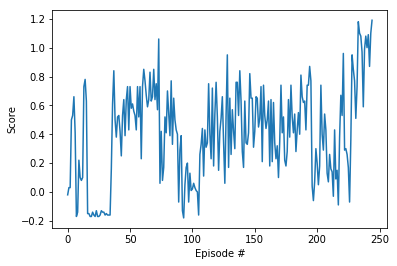

In [4]:
# plot the scores
fig = plt.figure()
# ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()